# Relax Challenge - Discovering Adopted Users
A user is considered an adopted user if they log into the product 3 separate days within a 7 day period.  We will investigate what factors can predict if a future user is likely to be an adopted user.

## Import Dataset

In [1]:
#import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read in user data
user = pd.read_csv('takehome_users.csv', parse_dates=['creation_time'], encoding='ISO-8859-1')

# Convert timestamp to datetime
user.last_session_creation_time = pd.to_datetime(user.last_session_creation_time, unit='s')
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [3]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [4]:
# Read in engagement data
engagement = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


The engagement dataframe gives information on each user's usage and tracks each day that they log into the product.  This will be a primary focus.

## Wrangle Data
In order to predict who can be an adopted user, we first have to identify adopted users (users who have logged in 3 separate days within a 7 day period).  We will first confirm that no user is logged in twice on the same day, then check to see if a user has logged in 3 separate days within a 7 day period.

We will then look at the missing data surrounding `last_session_creation_time` and `invited_by_user_id`

In [6]:
# Set user index to object_id, change name to user_id to align with engagement df
user.set_index('object_id', inplace=True)
user.index.name = 'user_id'

In [7]:
print(type(engagement.time_stamp[0]))
engagement.groupby(['user_id','time_stamp']).visited.count().head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


user_id  time_stamp         
1        2014-04-22 03:53:30    1
2        2013-11-15 03:45:04    1
         2013-11-29 03:45:04    1
         2013-12-09 03:45:04    1
         2013-12-25 03:45:04    1
Name: visited, dtype: int64

In [8]:
# Convert timestamp to datetime
engagement['time_stamp'] = engagement.time_stamp.dt.date

print(type(engagement.time_stamp[0]))
engagement.groupby(['user_id','time_stamp']).visited.count().head()

<class 'datetime.date'>


user_id  time_stamp
1        2014-04-22    1
2        2013-11-15    1
         2013-11-29    1
         2013-12-09    1
         2013-12-25    1
Name: visited, dtype: int64

In [9]:
# Confirm no user logged in twice on the same day
assert (engagement.groupby(['user_id','time_stamp']).visited.count() == 1).all()

In [10]:
# Create adopted_user column and set to 0 (not adopted)
user['adopted_user'] = 0

# Sort users by id and day, if user 2 spots away is same user, then all 3 spots is same user on different days
engagement.sort_values(['user_id', 'time_stamp'], inplace=True)

# Find adopted users, loop to last user minus 2 spots
for idx in engagement.index[:-2]:
    # Check if user 2 spots away is same user
    if engagement.loc[idx, 'user_id'] == engagement.loc[idx+2, 'user_id']:
        # Confirm log in is under 7 days
        if (engagement.loc[idx+2, 'time_stamp'] - engagement.loc[idx,'time_stamp']).days <= 7:
            # Retrieve user_id (same as index in user df)
            user_id = engagement.loc[idx, 'user_id']
            # Assign 1 to adopted user
            user.loc[user_id, 'adopted_user'] = 1
            
# Count number of adopted users vs. non-adopted users
user.adopted_user.value_counts()

0    10344
1     1656
Name: adopted_user, dtype: int64

There are 1,656 adopted users and 10,344 non-adopted users out of 12,000 total users.

In [11]:
# last_session_creation_time had several null values
user[user.last_session_creation_time.isnull()].adopted_user.value_counts()

0    3177
Name: adopted_user, dtype: int64

All entries with missing data in `last_session_creation_time` are from users who are non-adopted users.  We'll assume that they logged in once.

In [12]:
# Create 'invited' column to supplement missing values in 'invited_by_user_id' column
user['invited'] = user.invited_by_user_id.apply(lambda x: 0 if np.isnan(x) else 1)

In [13]:
user.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,invited
user_id,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,1
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,1
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,1
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,1
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,1


## Exploratory Data Analysis

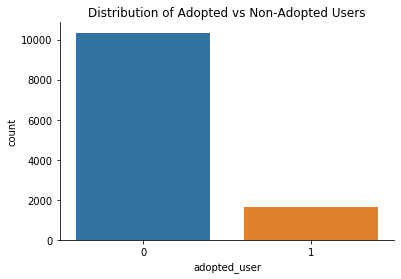

'Adopted users are 13.8% of all users and non-adopted users are 86.2% of all users'

In [14]:
# Distribution of Adopted vs Non-Adopted Usersx
ax = sns.countplot(x='adopted_user', data=user)
ax.set_title('Distribution of Adopted vs Non-Adopted Users')
sns.despine(top=True, right=True)
plt.show()

'Adopted users are {}% of all users and non-adopted users are {}% of all users'.format(
    len(user[user.adopted_user == 1])/len(user)*100, len(user[user.adopted_user == 0])/len(user)*100)

In [15]:
user.corr()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,invited
opted_in_to_mailing_list,1.000000,0.483529,0.003432,0.004699,0.008838,0.006934
enabled_for_marketing_drip,0.483529,1.000000,0.009275,0.003687,0.006578,0.002216
org_id,0.003432,0.009275,1.000000,-0.057780,0.066995,-0.018442
invited_by_user_id,0.004699,0.003687,-0.057780,1.000000,0.001185,NaN
adopted_user,0.008838,0.006578,0.066995,0.001185,1.000000,0.027831
invited,0.006934,0.002216,-0.018442,NaN,0.027831,1.000000


There's not much correlation between any of the columns above with the exception of `enabled_for_marketing_drip` and `opted_in_to_mailing_list`.

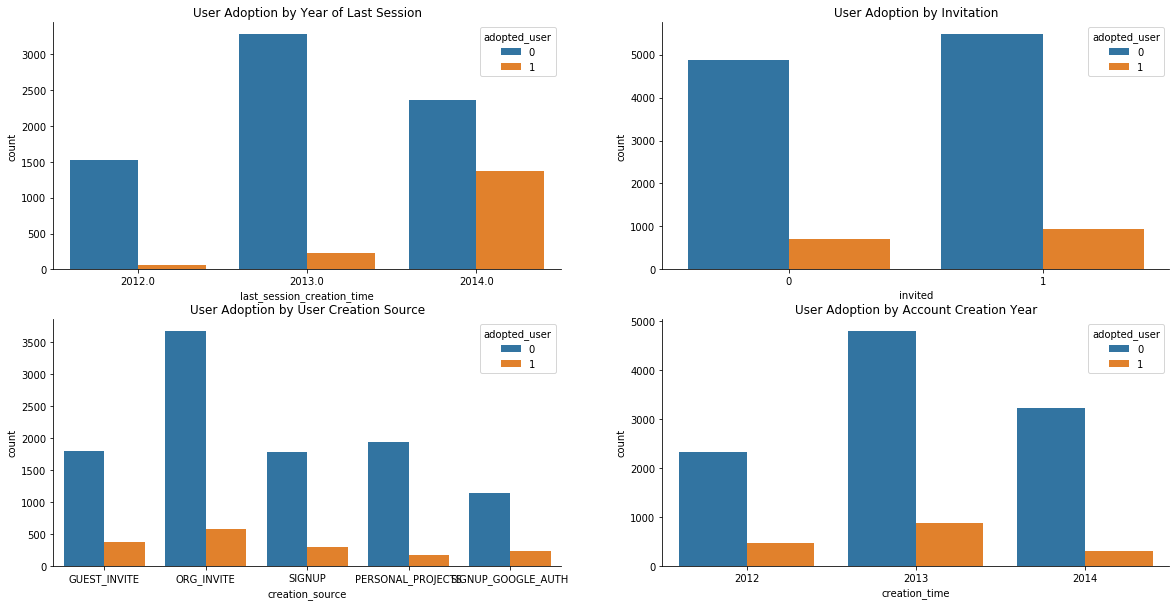

In [16]:
# look at categorical and datetime columns
plt.figure(figsize=(20,10));

ax1 = plt.subplot(2,2,1)
ax1 = sns.countplot(x=user.last_session_creation_time.dt.year, hue=user.adopted_user, ax=ax1)
ax1.set_title('User Adoption by Year of Last Session')

ax2 = plt.subplot(2,2,2)
ax2 = sns.countplot(x=user.invited, hue=user.adopted_user, ax=ax2)
ax2.set_title('User Adoption by Invitation')

ax3 = plt.subplot(2,2,3)
ax3 = sns.countplot(x='creation_source', hue='adopted_user', data=user, ax=ax3)
ax3.set_title('User Adoption by User Creation Source')

ax4 = plt.subplot(2,2,4)
ax4 = sns.countplot(x=user.creation_time.dt.year, hue=user.adopted_user, ax=ax4)
ax4.set_title('User Adoption by Account Creation Year')

sns.despine(top=True, right=True)
plt.show()

There's not very big correlation between many of the factors above with the major exception coming from `last_session_creation_time`, which shows that more adopted users logged in more recently than non-adopted users.

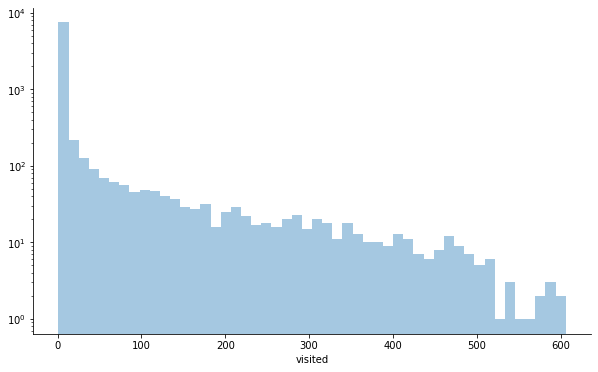

In [17]:
plt.figure(figsize=(10,6))
ax = sns.distplot(engagement.groupby('user_id').visited.count(), kde=False)
ax.set_yscale('log')
sns.despine(top=True, right=True)
plt.show()

Most users have only logged in 1 time, which would equate to non-adopted users, while a good portion have many log-ins, which would equate to adopted users.  This will be a good feature to look at when it comes to feature engineering.

## Feature Engineering

When it comes to feature engineering, there seems to be 2 things to really stick out:
- Number of times visited
- Creation date vs last usage date

We will use these 2 factors to create new columns (features) for our ML practice.  

But first, we need to deal with the users that have a missing value for their last usage date.  We will assume they logged in 1 day only, which is the minimum difference from creation and last usage date (0 days).

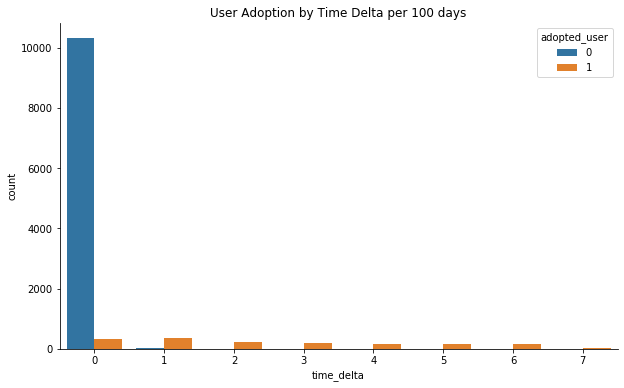

In [18]:
# Create time delta that measures the time a user first logged in vs. last
user['time_delta']= user.last_session_creation_time - user.creation_time

# Fill in missing time delta
user['time_delta'] = user.time_delta.fillna(user.time_delta.min())

plt.figure(figsize=(10,6))
sns.countplot(x=user.time_delta.dt.days//100, hue=user.adopted_user)
sns.despine(top=True, right=True)
plt.title('User Adoption by Time Delta per 100 days')
plt.show()

Almost all non-adopted users have a time delta of under 100 days, there are a small amount of non-adopted users between 100 and 200 days and any user that has a time delta of over 200 days is an adopted user.  There are, however a lot of adopted users that have a time delta of less than 100 days and time delta between 100 and 200 days.

In [19]:
# Create total number of visits column
total_visits = engagement.groupby('user_id').visited.count()
total_visits.name = 'total_visits'

# Join total number of visits to user dataframe
user = user.join(total_visits, on='user_id')

# Fill missing total visits to 1 for at least 1 visit
user.total_visits.fillna(1, inplace=True)

## Machine Learning Modeling

We're going to experiment on 3 different classification algorithms to determine which one performs the best.
- Logistic Regression (linear)
- Support Vector Machine (non-linear)
- Random Forest (ensemble)

Because there are 1,656 adopted users out of 12,000 (1,656 adopted vs 10,344 non-adopted), we are dealing with an imbalanced classification problem.  F1-Score and Area Under ROC will be used as metrics instead of accuracy score.

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score

In [21]:
# Prepare dataframe to model

# Convert cateogorical types
user['invited'] = user.invited.astype('category')
user['adopted_user'] = user.adopted_user.astype('category')
user['opted_in_to_mailing_list'] = user.opted_in_to_mailing_list.astype('category')
user['enabled_for_marketing_drip'] = user.enabled_for_marketing_drip.astype('category')

# Convert creation time to ordinal datetime
from datetime import datetime
user['creation_time_ordinal'] = user.creation_time.apply(datetime.toordinal)

# Convert time_delta to days
user['time_delta_day'] = user.time_delta.dt.days

In [22]:
# Extract features and target
X = user.drop(['creation_time','name','email','last_session_creation_time',
               'invited_by_user_id','adopted_user','time_delta'], axis=1)
y = user.adopted_user

# Create dummy variables from categorical columns
X = pd.get_dummies(X, drop_first=True)  # Convert categorical columns

# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=10)

In [23]:
# Create evaluation table
index = ['LogisticRegression','SVC','RandomForestClassifier']
eval_table = pd.DataFrame(index=index, columns= ['f1_score_train','auc_train','f1_score_test','auc_test'])

# Define function for plotting results
def compute_result(algorithm, pred_train, pred_test):
    """compute the performance for both training and test sets"""
    
    # Compute performace
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    auc_train = roc_auc_score(y_train, pred_train)
    auc_test = roc_auc_score(y_test, pred_test)
    
    # Log the performance
    eval_table.loc[algorithm,:] = f1_train, auc_train, f1_test, auc_test

In [24]:
# Fit default logistic regression model
logreg = Pipeline([('scaler', StandardScaler()),('logreg', LogisticRegression())])
logreg.fit(X_train, y_train)
pred_train = logreg.predict(X_train)
pred_test = logreg.predict(X_test)

# Show features and their coefficients
feature_coef = pd.DataFrame({'feature':X_train.columns, 'coefficient':logreg.named_steps.logreg.coef_[0]})
print(feature_coef.sort_values('coefficient',ascending=False))

# Record model performance
compute_result('LogisticRegression', pred_train, pred_test)

                               feature  coefficient
1                         total_visits     9.851416
3                       time_delta_day     5.556038
2                creation_time_ordinal     0.338954
0                               org_id     0.184048
8           opted_in_to_mailing_list_1     0.032066
10                           invited_1     0.028366
9         enabled_for_marketing_drip_1     0.013917
7   creation_source_SIGNUP_GOOGLE_AUTH     0.011976
6               creation_source_SIGNUP     0.007863
5    creation_source_PERSONAL_PROJECTS    -0.055173
4           creation_source_ORG_INVITE    -0.094157


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [25]:
# Fit default support vector machine model
svc = Pipeline([('scaler', StandardScaler()),('svc', SVC())])
svc.fit(X_train, y_train)
pred_train = svc.predict(X_train)
pred_test = svc.predict(X_test)

# Record model performance
compute_result('SVC', pred_train, pred_test)

In [26]:
# Fit default random forest model

# Set class_weight to 'balanced' to adjust for the imbalanced classes
rfc = Pipeline([('scaler', StandardScaler()),('rfc', RandomForestClassifier(class_weight='balanced'))]) 
rfc.fit(X_train, y_train)
pred_train = rfc.predict(X_train)
pred_test = rfc.predict(X_test)

# Print feature importance
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': rfc.named_steps.rfc.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False))

# Record model performance
compute_result('RandomForestClassifier', pred_train, pred_test)

                               feature  importance
1                         total_visits    0.665941
3                       time_delta_day    0.269177
2                creation_time_ordinal    0.029332
0                               org_id    0.021527
5    creation_source_PERSONAL_PROJECTS    0.005337
8           opted_in_to_mailing_list_1    0.002097
7   creation_source_SIGNUP_GOOGLE_AUTH    0.001745
4           creation_source_ORG_INVITE    0.001554
9         enabled_for_marketing_drip_1    0.001456
10                           invited_1    0.001079
6               creation_source_SIGNUP    0.000755


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [27]:
# Show results of each model's performance
eval_table

,f1_score_train,auc_train,f1_score_test,auc_test
LogisticRegression,0.913997,0.933428,0.913486,0.931061
SVC,0.906049,0.922994,0.902975,0.919564
RandomForestClassifier,0.994743,0.995105,0.933498,0.954056


## Optimizing Random Forest through Hypertuning
By default, the RandomForestClassifier has the best f1 score and AUC score, and the ability to balance the imbalanced classification helped in its scoring.  We will now hypertune the model to improve its score.

In [28]:
# Use gridsearchcv to optimize the RandomForestClassifier
# The default parameters seem to overfit to the training set

parameters = {'rfc__n_estimators': np.arange(10,90,7), 'rfc__max_features':['auto','sqrt','log2']}

# Scoring criteria: f1_score gives better sensitivity with a wider range of scoring distribution for imbalanced
rfc_cv = GridSearchCV(rfc, parameters, scoring='f1', cv=5)
rfc_cv.fit(X_train, y_train)
print('Best parameters:', rfc_cv.best_params_)
print('Corresponding f1 score:', rfc_cv.best_score_)

Best parameters: {'rfc__max_features': 'sqrt', 'rfc__n_estimators': 87}
Corresponding f1 score: 0.94621710700124


In [29]:
# Hypertuned RandomForestClassifier
rfc = Pipeline([('scaler', StandardScaler()),
                ('rfc', RandomForestClassifier(n_estimators=80, 
                                               max_features='log2', 
                                               class_weight='balanced'))])
rfc.fit(X_train, y_train)
pred_train = rfc.predict(X_train)
pred_test = rfc.predict(X_test)

# Record model performance
compute_result("RandomForestClassifier", pred_train, pred_test)

In [30]:
# Feature importance ranking of hypertuned RandomForestClassifier 
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': rfc.named_steps.rfc.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False))

# Final result
pd.DataFrame(eval_table.loc['RandomForestClassifier'])

                               feature  importance
1                         total_visits    0.559257
3                       time_delta_day    0.383756
2                creation_time_ordinal    0.028110
0                               org_id    0.017484
5    creation_source_PERSONAL_PROJECTS    0.002653
8           opted_in_to_mailing_list_1    0.001851
4           creation_source_ORG_INVITE    0.001712
9         enabled_for_marketing_drip_1    0.001436
10                           invited_1    0.001369
7   creation_source_SIGNUP_GOOGLE_AUTH    0.001299
6               creation_source_SIGNUP    0.001074


,RandomForestClassifier
f1_score_train,1
auc_train,1
f1_score_test,0.94621
auc_test,0.964104


The hypertuned RandomForestClassifier gives us the best results in classifying whether a new user will be an adopted user with the most important features being `total_visits` and `time_delta_day`.